# Training Mars Landmark Identifier Model with Convolutional Neural Network

### Python 2/3 Compatibility Import

In [1]:
### Python 2/3 Compatibility Import
from __future__ import absolute_import, division, print_function, unicode_literals

### Imports

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os # for parallelization

### Load Data

#### Pre-processing Functions

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [4]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [5]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#### Declarations

In [6]:
# Mars Landmark Classes
CLASS_NAMES = np.array([
    "other",
    "crater",
    "dark dune",
    "slope streak",
    "bright dune",
    "impact ejecta",
    "swiss cheese",
    "spider",
])

# Image Size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

#### Loading

In [7]:
train_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/training/*/*"))
train_ds = train_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
test_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/testing/*/*"))
test_ds = test_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
# Check Data
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Image: ", image.numpy())
    print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Image:  [[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.47760844 0.47760844 0.47760844]
  [0.46051747 0.46051747 0.46051747]
  [0.520538   0.520538   0.520538  ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.3817616  0.3817616  0.3817616 ]
  [0.42498782 0.42498782 0.42498782]
  [0.56152385 0.56152385 0.56152385]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.30175722 0.30175722 0.30175722]
  [0.489226   0.489226   0.489226  ]
  [0.54946786 0.54946786 0.54946786]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.5398937  0.5398937  0.5398937 ]
  [0.567105   0.567105   0.567105  ]
  [0.5834188  0.5834188  0.5834188 ]]

 [[0.         0.         0.        ]
 

#### Batching

In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [11]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [12]:
X_train = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(X_train))

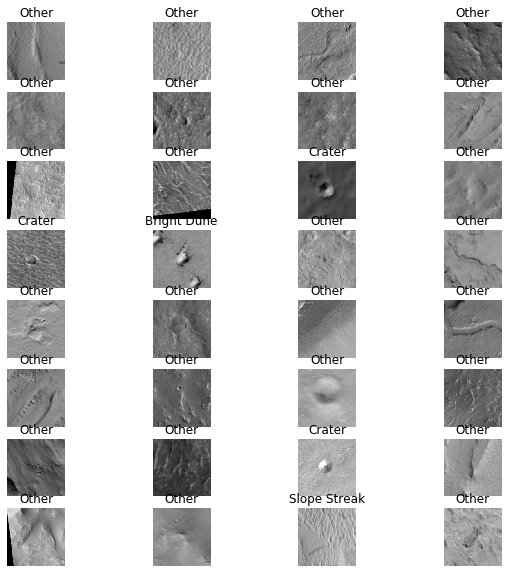

In [13]:
# Preview batch
show_batch(image_batch.numpy(), label_batch.numpy())

### Modeling

In [14]:
# CNN Model
model = Sequential(name="MLI_CNN")
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

Model: "MLI_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211

### Compile & Train

In [15]:
# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Logs for Tensorboard
if os.name == "nt":
    log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
else:
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
# Fitting
MLI_FIT = model.fit(X_train,
                    epochs=10,
                    steps_per_epoch=100,
                    callbacks=[tensorboard_callback],
                    validation_data=prepare_for_training(test_ds),
                    validation_steps=50
                    )
# Save Model
if os.name == "nt":
    model.save("models\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")
else:
    model.save("models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 11s 112ms/step - loss: 0.2347 - accuracy: 0.9234 - val_loss: 1.9379 - val_accuracy: 0.4850
Epoch 2/10
100/100 [==============================] - 4s 43ms/step - loss: 0.2445 - accuracy: 0.9225 - val_loss: 2.2160 - val_accuracy: 0.4775
Epoch 3/10
100/100 [==============================] - 6s 61ms/step - loss: 0.2362 - accuracy: 0.9262 - val_loss: 1.9167 - val_accuracy: 0.4750
Epoch 4/10
100/100 [==============================] - 7s 68ms/step - loss: 0.2224 - accuracy: 0.9253 - val_loss: 2.1892 - val_accuracy: 0.4575
Epoch 5/10
100/100 [==============================] - 8s 81ms/step - loss: 0.2625 - accuracy: 0.9147 - val_loss: 2.0673 - val_accuracy: 0.4675
Epoch 6/10
100/100 [==============================] - 9s 93ms/step - loss: 0.2499 - accuracy: 0.9212 - val_loss: 2.0588 - val_accuracy: 0.4525loss: 0.2120 - accuracy: 0.92 - ETA: 4s - loss: 0.2174 - accura - ETA: 4s - loss: 0.2394  - ETA: 3

### Evaluate

In [30]:
test_loss, test_acc = model.evaluate(prepare_for_training(test_ds), steps=10, verbose=2)

10/10 - 0s - loss: 1.7051 - accuracy: 0.5312


### Prediction

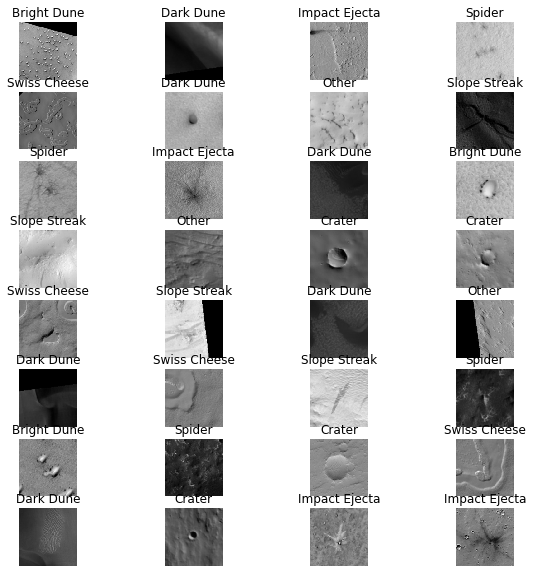

In [19]:
predict = prepare_for_training(test_ds)

prd_img, prd_lbl = next(iter(predict))

show_batch(prd_img.numpy(), prd_lbl.numpy())

In [20]:
model.predict(prd_img.numpy(),steps=1).round()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 